In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import os
import shutil
import random
import itertools
%matplotlib inline

In [2]:
mobile = tf.keras.applications.MobileNetV3Large(
    input_shape=None,
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
    

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\applications\mobilenet_v3.py:512: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [164]:
mobile.summary()

Model: "MobilenetV3large"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, None, None, 3)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_6 (Rescaling)       │ (None, None, None, 3)     │               0 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv (Conv2D)                 │ (None, None, None, 16)    │             432 │ rescaling_6[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_bn (BatchNormalization)  │ (None, None, None, 16)    │              64 │ conv[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_122 (Activation)   │ (None, None, None, 16)    │               0 │ conv_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, None, None, 16)    │             144 │ activation_122[0][0]       │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_bn    │ (None, None, None, 16)    │              64 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_114 (ReLU)              │ (None, None, None, 16)    │               0 │ expanded_conv_depthwise_b… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, None, None, 16)    │             256 │ re_lu_114[0][0]            │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_bn      │ (None, None, None, 16)    │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_add (Add)       │ (None, None, None, 16)    │               0 │ activation_122[0][0],      │
│                               │                           │                 │ expanded_conv_project_bn[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_1_expand        │ (None, None, None, 64)    │           1,024 │ expanded_conv_add[0][0]    │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_1_expand_bn     │ (None, None, None, 64)    │             256 │ expanded_conv_1_expand[0]… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_115 (ReLU)              │ (None, None, None, 64)    │               

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 2,971,952 (11.34 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [3]:
def prepare_image(file):
    img_path='data/'
    img = image.load_img(img_path + file,target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array,axis=0)
    return tf.keras.applications.mobilenet_v3.preprocess_input(img_array_expanded_dims)

In [12]:
preprocessed_image=prepare_image('1.png')
predictions=mobile.predict(preprocessed_image)
results=imagenet_utils.decode_predictions(predictions)
results

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


[[('n07714571', 'head_cabbage', 0.4061652),
  ('n12768682', 'buckeye', 0.13437812),
  ('n03991062', 'pot', 0.0624845),
  ('n07715103', 'cauliflower', 0.05029423),
  ('n02280649', 'cabbage_butterfly', 0.022095984)]]

In [ ]:
import os
import shutil
import random
l = ['Indian_Mustard','Jackfruit','Jamaica_Cherry-Gasagase','Jamun','Jasmine','Karanda','Lemon','Mango','Mexican_Mint','Mint']
if not os.path.isdir('train'):
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')   
    for item in l:
        shutil.move(item, 'train')
        os.mkdir(os.path.join('valid', item))
        os.mkdir(os.path.join('test', item))
        valid_samples = random.sample(os.listdir(os.path.join('train', item)), 30)
        for sample in valid_samples:
            shutil.move(os.path.join('train', item, sample), os.path.join('valid', item))
        test_samples = random.sample(os.listdir(os.path.join('train', item)), 5)
        for sample in test_samples:
            shutil.move(os.path.join('train', item, sample), os.path.join('test', item))

In [ ]:
os.getcwd()
os.chdir('medicinal herb identification/')
os.getcwd()

In [4]:
train_path='dataset/train'
valid_path='dataset/valid'
test_path='dataset/test'

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input).flow_from_directory(directory=train_path,target_size=(224,224),batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input).flow_from_directory(directory=valid_path,target_size=(224,224),batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input).flow_from_directory(directory=test_path,target_size=(224,224),batch_size=10,shuffle=False)

Found 4360 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [56]:
#real_path='dataset/real'
#real_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input).flow_from_directory(directory=real_path,target_size=(224,224),batch_size=1,shuffle=True)

In [6]:
mobile.summary()

Model: "MobilenetV3large"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, None, None, 3)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, None, None, 3)     │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv (Conv2D)                 │ (None, None, None, 16)    │             432 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_bn (BatchNormalization)  │ (None, None, None, 16)    │              64 │ conv[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, None, None, 16)    │               0 │ conv_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, None, None, 16)    │             144 │ activation[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_bn    │ (None, None, None, 16)    │              64 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu (ReLU)                  │ (None, None, None, 16)    │               0 │ expanded_conv_depthwise_b… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, None, None, 16)    │             256 │ re_lu[0][0]                │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_bn      │ (None, None, None, 16)    │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_add (Add)       │ (None, None, None, 16)    │               0 │ activation[0][0],          │
│                               │                           │                 │ expanded_conv_project_bn[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_1_expand        │ (None, None, None, 64)    │           1,024 │ expanded_conv_add[0][0]    │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_1_expand_bn     │ (None, None, None, 64)    │             256 │ expanded_conv_1_expand[0]… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_1 (ReLU)                │ (None, None, None, 64)    │               

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 2,971,952 (11.34 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [7]:
from keras.layers import GlobalAveragePooling2D, Dense

In [8]:
x=mobile.layers[-7].output
output=Dense(units=10,activation='softmax')(x)
x = mobile.output
x = GlobalAveragePooling2D()(x)
output = Dense(10, activation='softmax')(x)

In [9]:
model=Model(inputs=mobile.input,outputs=output)

In [10]:
for layer in model.layers[:-23]:
    layer.trainable=False

In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, None, None, 3)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, None, None, 3)     │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv (Conv2D)                 │ (None, None, None, 16)    │             432 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_bn (BatchNormalization)  │ (None, None, None, 16)    │              64 │ conv[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, None, None, 16)    │               0 │ conv_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, None, None, 16)    │             144 │ activation[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_bn    │ (None, None, None, 16)    │              64 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu (ReLU)                  │ (None, None, None, 16)    │               0 │ expanded_conv_depthwise_b… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, None, None, 16)    │             256 │ re_lu[0][0]                │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_bn      │ (None, None, None, 16)    │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_add (Add)       │ (None, None, None, 16)    │               0 │ activation[0][0],          │
│                               │                           │                 │ expanded_conv_project_bn[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_1_expand        │ (None, None, None, 64)    │           1,024 │ expanded_conv_add[0][0]    │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_1_expand_bn     │ (None, None, None, 64)    │             256 │ expanded_conv_1_expand[0]… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_1 (ReLU)                │ (None, None, None, 64)    │               

 Total params: 3,005,962 (11.47 MB)

 Trainable params: 1,116,410 (4.26 MB)

 Non-trainable params: 1,889,552 (7.21 MB)

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [13]:
model.fit(x=train_batches,validation_data=valid_batches,epochs=30,verbose=2)

Epoch 1/30


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


436/436 - 38s - 88ms/step - accuracy: 0.9333 - loss: 0.2874 - val_accuracy: 0.9467 - val_loss: 0.2051
Epoch 2/30
436/436 - 30s - 68ms/step - accuracy: 0.9993 - loss: 0.0129 - val_accuracy: 1.0000 - val_loss: 0.0262
Epoch 3/30
436/436 - 30s - 68ms/step - accuracy: 0.9995 - loss: 0.0063 - val_accuracy: 1.0000 - val_loss: 0.0062
Epoch 4/30
436/436 - 29s - 67ms/step - accuracy: 0.9998 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 9.2371e-04
Epoch 5/30
436/436 - 29s - 67ms/step - accuracy: 0.9998 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 3.9590e-04
Epoch 6/30
436/436 - 29s - 67ms/step - accuracy: 0.9998 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 2.6774e-04
Epoch 7/30
436/436 - 29s - 67ms/step - accuracy: 0.9993 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 5.4911e-04
Epoch 8/30
436/436 - 32s - 73ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 1.2054e-04
Epoch 9/30
436/436 - 40s - 92ms/step - accuracy: 1.0000 - loss: 5.1090e-04 - val_accura

In [14]:
test_labels = test_batches.classes

In [15]:
predictions=model.predict(x=test_batches,verbose=0)

In [16]:
cm=confusion_matrix(y_true=test_labels,y_pred=predictions.argmax(axis=1))

In [17]:
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
test_batches.class_indices

{'Indian_Mustard': 0,
 'Jackfruit': 1,
 'Jamaica_Cherry-Gasagase': 2,
 'Jamun': 3,
 'Jasmine': 4,
 'Karanda': 5,
 'Lemon': 6,
 'Mango': 7,
 'Mexican_Mint': 8,
 'Mint': 9}

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


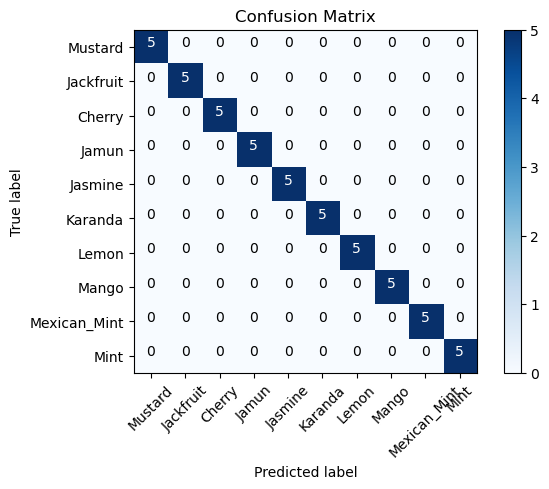

In [19]:
cm_plot_labels=['Mustard', 'Jackfruit', 'Cherry', 'Jamun', 'Jasmine', 'Karanda', 'Lemon', 'Mango', 'Mexican_Mint', 'Mint']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')

In [67]:
os.getcwd()
os.chdir('/

'C:\\Users\\asus\\Documents\\medicinal herb identification'

In [45]:
aimage='16.png'
preprocessed_image=prepare_image(aimage)
predictions=model.predict(preprocessed_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [21]:
for i in predictions:
    print(i)

[2.9751163e-02 4.4294762e-07 2.6121350e-07 7.4843098e-07 1.1783538e-06
 1.7757639e-08 7.8864906e-07 2.7787598e-04 4.7847518e-04 9.6948910e-01]


[['Jamun' 'Jackfruit' 'Mango']]


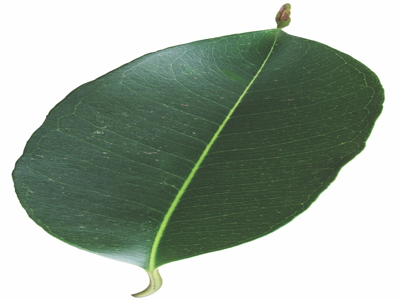

In [46]:
import numpy as np
top3_indices = np.argsort(predictions, axis =- 1) [:, -3:]
reversed_top3_indices = np.flip(top3_indices, axis =- 1)
top3_class_names = np.empty_like(reversed_top3_indices, dtype=object)
for i, row in enumerate(reversed_top3_indices):
    for j, idx in enumerate(row):
        top3_class_names[i, j] = cm_plot_labels[idx]
print(top3_class_names)
from PIL import Image
def show_image_with_size(image_path, width, height):
    img = Image.open(image_path)
    img_resized = img.resize((width, height))  
    display(img_resized)
image_path = "data/"+aimage
desired_width = 400
desired_height = 300
show_image_with_size(image_path, desired_width, desired_height)

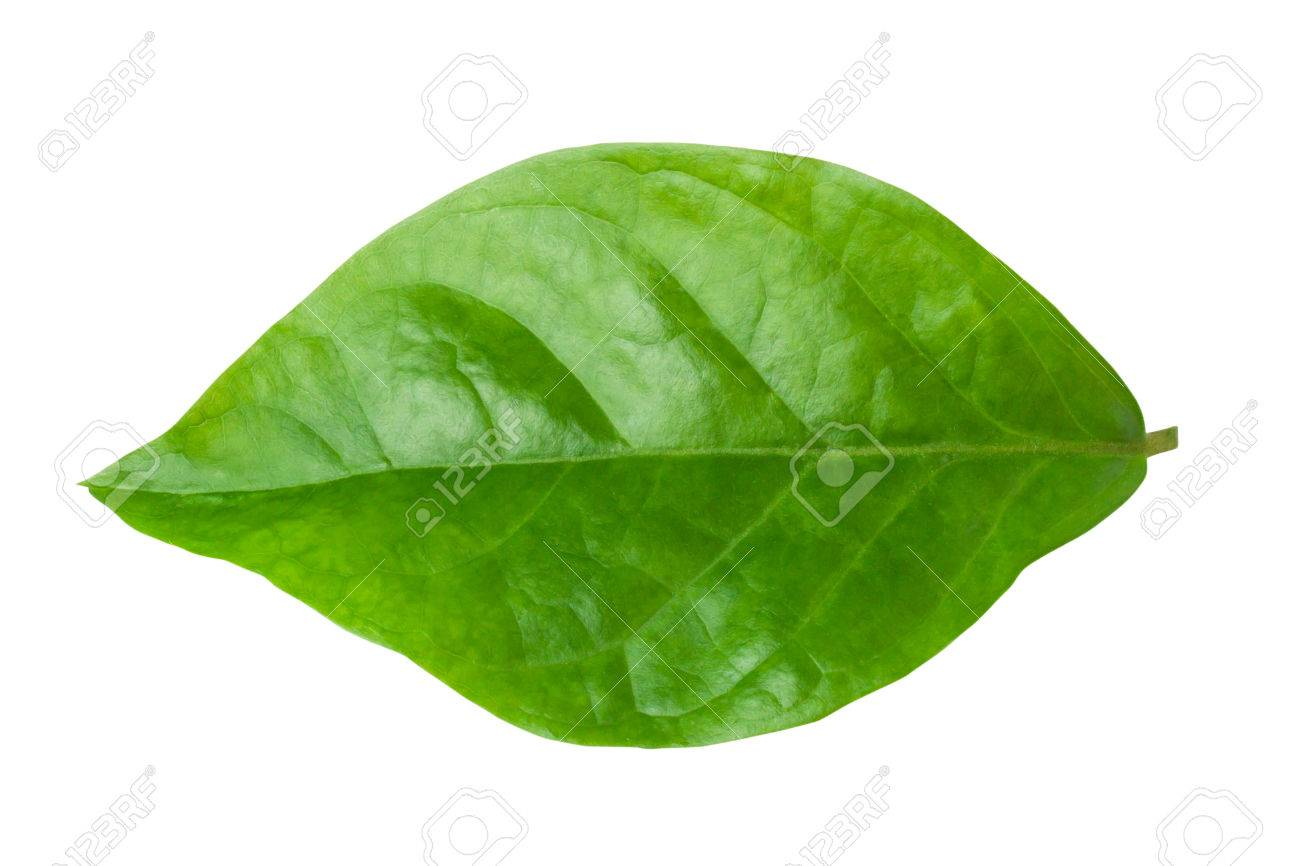

In [22]:
from IPython.display import Image
Image(filename='data/8.png',width=300,height=300)

In [50]:
if os.path.isfile('models/medicinal_herb_model2.h5') is False:
    model.save('models/medicinal_herb_model2.h5')

In [51]:
from tensorflow.keras.models import save_model
model_file_path = 'models/medicinal_herb_model.keras'
if not os.path.isfile('models/medicinal_herb_model.keras'):
    save_model(model,'models/medicinal_herb_model.keras')

In [1]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have trained your classifier and obtained predictions
predicted_probabilities = classifier.predict_proba(test_features)

# Assuming you have defined true_labels
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities[:, 1])  # Considering probabilities for the positive class

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Calculate AUC
auc = roc_auc_score(true_labels, predicted_probabilities[:, 1])  # Considering probabilities for the positive class


NameError: name 'classifier' is not defined